2) Implemente uma regressão logística Bayesiana para o dataset Iris: https://archive.ics.uci.edu/dataset/53/iris

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import numpy as np
import pytensor.tensor as tt
import pandas as pd

In [55]:
from sklearn.datasets import load_iris
iris = load_iris()

In [56]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df_bin = df[df['target'] != 2]
display(df)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [57]:
x_f = df_bin.drop(columns=['target'])
y_f = df_bin['target']


In [58]:
x_f["sepal length (cm)"] = (x_f["sepal length (cm)"]-x_f["sepal length (cm)"].mean())/x_f["sepal length (cm)"].std()
x_f["sepal width (cm)"] = (x_f["sepal width (cm)"]-x_f["sepal width (cm)"].mean())/x_f["sepal width (cm)"].std()
x_f["petal length (cm)"] = (x_f["petal length (cm)"]-x_f["petal length (cm)"].mean())/x_f["petal length (cm)"].std()
x_f["petal width (cm)"] = (x_f["petal width (cm)"]-x_f["petal width (cm)"].mean())/x_f["petal width (cm)"].std()
display(x_f)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.578153,0.837617,-1.007900,-1.036887
1,-0.889826,-0.206793,-1.007900,-1.036887
2,-1.201499,0.210971,-1.076887,-1.036887
3,-1.357336,0.002089,-0.938913,-1.036887
4,-0.733990,1.046500,-1.007900,-1.036887
...,...,...,...,...
95,0.356865,-0.206793,0.923736,0.732545
96,0.356865,-0.415675,0.923736,0.909488
97,1.136048,-0.415675,0.992723,0.909488
98,-0.578153,-1.251204,0.095892,0.555602


In [59]:
from sklearn.model_selection import train_test_split

x_treino, x_teste, y_treino, y_teste = train_test_split(x_f, y_f, test_size=0.3)

display(x_treino)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
79,0.356865,-1.042322,0.440827,0.378658
8,-1.669009,-0.415675,-1.007900,-1.036887
40,-0.733990,0.837617,-1.076887,-0.859944
58,1.759394,-0.415675,1.199684,0.909488
52,2.226903,0.002089,1.406645,1.263375
...,...,...,...,...
50,2.382740,0.210971,1.268671,1.086431
98,-0.578153,-1.251204,0.095892,0.555602
44,-0.578153,1.464264,-0.662965,-0.683001
53,0.045193,-1.668968,0.785762,0.909488


In [60]:
display(y_teste)

,target
82,1
27,0
76,1
10,0
89,1
36,0
69,1
61,1
29,0
17,0


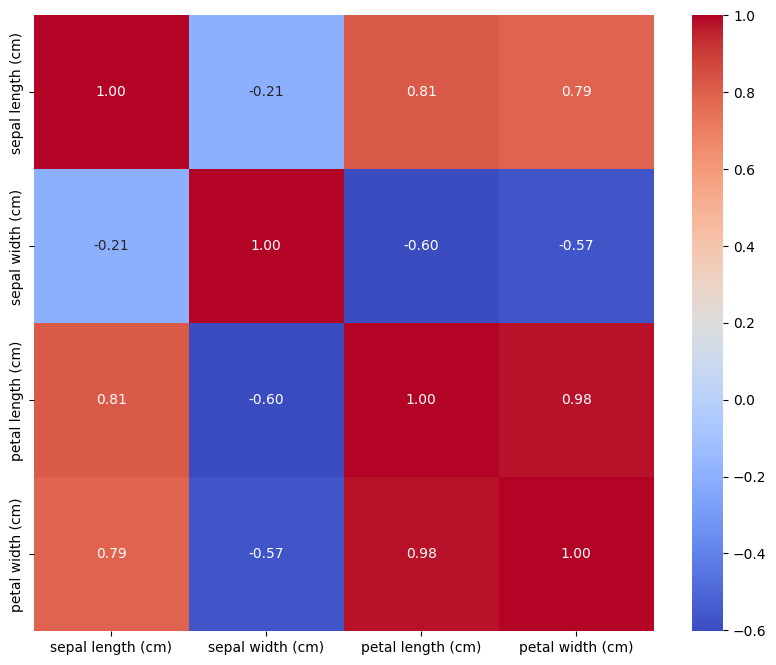

In [61]:
plt.figure(figsize=(10,8))
sns.heatmap(x_f.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

In [62]:
coords = {
    'features': ['sepal length (cm)',	'sepal width (cm)'	,'petal length (cm)',	'petal width (cm)']
}

In [63]:
with pm.Model(coords=coords) as model:
  betas = pm.Normal("beta",0,1,dims="features")
  alpha = pm.Normal("alpha",0,1)

  X = [
    pm.MutableData("x_"+column,x_treino[column].values)
    for column in x_treino.columns if np.issubdtype(x_f[column].dtype, np.number)
  ]

  y = pm.MutableData("y",y_treino)

  mu = alpha + tt.dot(betas,X)
  likelihood = pm.Bernoulli("likelihood",pm.math.invlogit(mu),observed=y)

/usr/local/lib/python3.11/dist-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


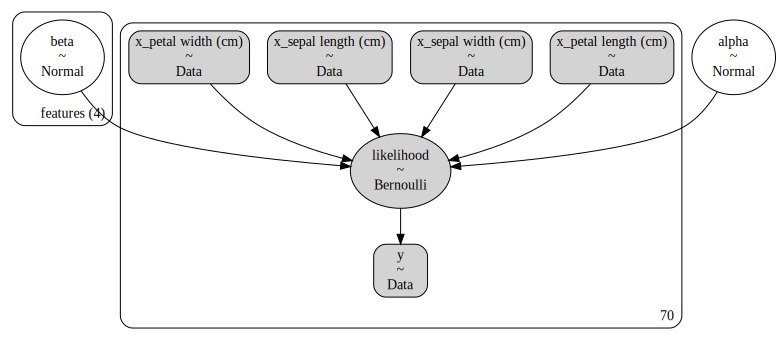

In [64]:
pm.model_to_graphviz(model)

In [73]:
with model:
  approx = pm.fit(10000)

Output()

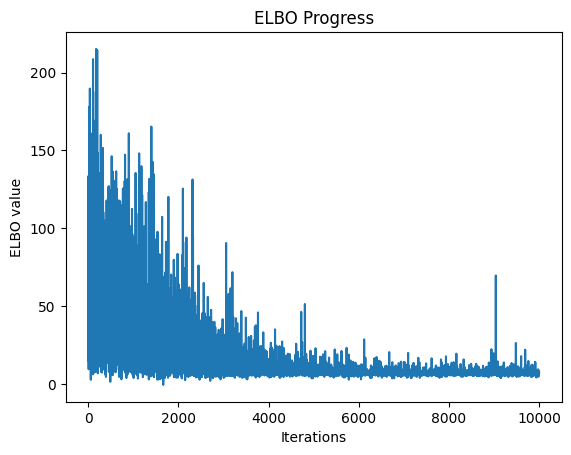

In [74]:
plt.plot(approx.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [75]:
with model:
  trace = approx.sample(10000)

In [76]:
pm.summary(trace)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.072,0.610,-1.035,1.235,0.006,0.004,9950.0,9570.0,NaN
beta[sepal length (cm)],0.953,0.672,-0.382,2.172,0.007,0.005,9918.0,9686.0,NaN
beta[sepal width (cm)],-1.256,0.596,-2.377,-0.108,0.006,0.004,9462.0,9815.0,NaN
beta[petal length (cm)],1.556,0.684,0.242,2.808,0.007,0.005,9791.0,9881.0,NaN
beta[petal width (cm)],1.596,0.680,0.382,2.924,0.007,0.005,9925.0,9726.0,NaN


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

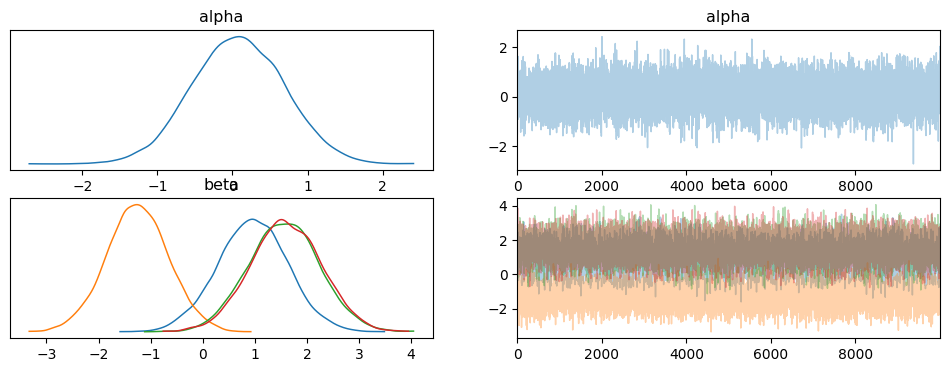

In [77]:
az.plot_trace(trace)

In [78]:
vars = {"x_"+column : x_teste[column].values
    for column in x_teste.columns if np.issubdtype(x_teste[column].dtype, np.number)}
vars["y"] = y_teste

In [79]:
with model:
  pm.set_data(vars)
  trace_post = pm.sample_posterior_predictive(trace)

Output()

In [80]:
mean_likelihood = trace_post.posterior_predictive['likelihood'].mean(dim=['chain', 'draw'])
predicao = (mean_likelihood > 0.5).astype(int)

In [85]:
abs_diff = np.abs(y_teste - predicao)

df = pd.DataFrame({
    'y_test': y_teste,
    'Predição': predicao,
    'Difenreça absoluta': abs_diff
})

display(df)

,y_test,Predição,Difenreça absoluta
82,1,1,0
27,0,0,0
76,1,1,0
10,0,0,0
89,1,1,0
36,0,0,0
69,1,1,0
61,1,1,0
29,0,0,0
17,0,0,0


In [88]:
errors = df["Difenreça absoluta"].sum()
acc = (len(df)-errors)/len(df)
print(f"Acuracia: {acc:.4f}")
print(f"Erros: {errors}")

Acuracia: 1.0000
Erros: 0


In [89]:
class1 = df["y_test"].sum()
class0 = len(df)-class1

print(f"Classe 0: {class0}")
print(f"Classe 1: {class1}")

Classe 0: 12
Classe 1: 18


In [91]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_teste, predicao)

recall = recall_score(y_teste, predicao)

f1 = f1_score(y_teste, predicao)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
